In [1]:
import numpy as np
import pandas as pd; pd.options.display.float_format = '{:.5f}'.format
from scipy import stats
import math
import cvxpy as cvx
from numpy import matrix 
from cvxpy import *
from itertools import chain
import matplotlib.pyplot as plt

## Part A: Portfolio Optimization based on the Full Data Set

### 1. Preparing the data

In [2]:
stocks = pd.read_excel('datahomework2.xls')
stocks.head()

,Amazon,Apple,Ebay,Facebook,Google,Twitter
0,252.58500,106.25000,23.45760,77.19000,519.50000,36.38000
1,245.48800,106.26000,23.15670,76.15000,506.60001,37.28000
2,253.81600,107.75000,23.11670,76.15000,505.20001,39.09000
3,256.03000,111.89000,23.74170,78.17500,506.89999,40.17000
4,253.29900,112.01000,23.41340,77.74000,500.70001,39.37000


#### A. Based on the data set, compute the rate of returns for each stock

In [3]:
rate_returns = (stocks.shift(-1) - stocks)/stocks
rate_returns.dropna(inplace=True)
rate_returns.head()

,Amazon,Apple,Ebay,Facebook,Google,Twitter
0,-0.02810,0.00009,-0.01283,-0.01347,-0.02483,0.02474
1,0.03392,0.01402,-0.00173,0.00000,-0.00276,0.04855
2,0.00872,0.03842,0.02704,0.02659,0.00336,0.02763
3,-0.01067,0.00107,-0.01383,-0.00556,-0.01223,-0.01992
4,-0.02846,-0.02464,-0.00773,-0.01312,-0.00719,0.00711


#### B. Based on the data set, compute the average returns that will be used for the optimization

In [4]:
avg_returns = stats.gmean(rate_returns+1, axis=0)-1
avg_returns

array([  1.98778605e-03,   6.25712685e-04,   7.54726158e-04,
         1.08819147e-03,   9.73603071e-04,  -2.78636077e-05])

#### C. Based on the data set, compute the variance-covariance matrix of the stock returns

In [5]:
covariance_matrix = rate_returns.cov()
covariance_matrix

,Amazon,Apple,Ebay,Facebook,Google,Twitter
Amazon,0.00041,0.00000,0.00001,-0.00001,0.00001,-0.00010
Apple,0.00000,0.00021,0.00006,0.00007,0.00006,0.00004
Ebay,0.00001,0.00006,0.00029,0.00003,0.00005,0.00002
Facebook,-0.00001,0.00007,0.00003,0.00024,0.00010,0.00002
Google,0.00001,0.00006,0.00005,0.00010,0.00020,0.00001
Twitter,-0.00010,0.00004,0.00002,0.00002,0.00001,0.00107


#### D. Provide the vector 𝜇 and the variance-covariance matrix 𝛴 for the 6 assets considered

In [6]:
# the vector 𝜇 = rate_returns
print('the vector 𝜇 = rate_returns:')
rate_returns.head()

the vector 𝜇 = rate_returns:


,Amazon,Apple,Ebay,Facebook,Google,Twitter
0,-0.02810,0.00009,-0.01283,-0.01347,-0.02483,0.02474
1,0.03392,0.01402,-0.00173,0.00000,-0.00276,0.04855
2,0.00872,0.03842,0.02704,0.02659,0.00336,0.02763
3,-0.01067,0.00107,-0.01383,-0.00556,-0.01223,-0.01992
4,-0.02846,-0.02464,-0.00773,-0.01312,-0.00719,0.00711


In [7]:
# the variance-covariance matrix = covariance_matrix
print('the variance-covariance matrix = covariance_matrix:')
covariance_matrix

the variance-covariance matrix = covariance_matrix:


,Amazon,Apple,Ebay,Facebook,Google,Twitter
Amazon,0.00041,0.00000,0.00001,-0.00001,0.00001,-0.00010
Apple,0.00000,0.00021,0.00006,0.00007,0.00006,0.00004
Ebay,0.00001,0.00006,0.00029,0.00003,0.00005,0.00002
Facebook,-0.00001,0.00007,0.00003,0.00024,0.00010,0.00002
Google,0.00001,0.00006,0.00005,0.00010,0.00020,0.00001
Twitter,-0.00010,0.00004,0.00002,0.00002,0.00001,0.00107


### 2. Portfolio Optimization: Minimizing Risk

In [8]:
R = 0.07/250
mu = avg_returns
Cov = covariance_matrix.values
x = cvx.Variable(6)

risk = quad_form(x, Cov)
rr = sum_entries(mu*x)
prob1 = Problem(Minimize(risk), 
               [rr >= R,sum_entries(x) == 1, 
                x >= 0])
prob1.solve()

allocation_min_risk = pd.DataFrame(x.value.T, columns = stocks.columns, index = ['Allocation'])
print(f'the optimum value is: {round(prob1.value, 5)}')
allocation_min_risk

the optimum value is: 8e-05


,Amazon,Apple,Ebay,Facebook,Google,Twitter
Allocation,0.20426,0.19549,0.16170,0.17376,0.18986,0.07494


### 3. Portfolio Optimization: Maximizing Returns (or Utility)

In [9]:
gamma = [0.10, 0.15, 0.20]
mu = avg_returns
Cov = covariance_matrix.values
x = cvx.Variable(6)

risk = quad_form(x, Cov)
rr = sum_entries(mu*x)

allocation_max_returns_list = []
optimum_value = []
for g in gamma:
    prob2 = Problem(Maximize(rr - g*risk), 
                   [sum_entries(x) == 1, 
                    x >= 0])
    prob2.solve()

    allocation_max_returns_list.append(pd.DataFrame(x.value.T))
    optimum_value.append(prob2.value)
    
allocation_max_returns = pd.concat([allocation_max_returns_list[0], allocation_max_returns_list[1], allocation_max_returns_list[2]])
allocation_max_returns.columns = stocks.columns
allocation_max_returns.index = list(map(lambda x: '𝛾='+ str(x), gamma))
allocation_max_returns['optimum_value'] = optimum_value

allocation_max_returns

,Amazon,Apple,Ebay,Facebook,Google,Twitter,optimum_value
𝛾=0.1,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00195
𝛾=0.15,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00193
𝛾=0.2,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00191


### 4. Simulations

#### Portfolio Optimization: Minimizing Risk

In [10]:
simu = 1000 # I am doing 1000 simulations
T = 300 # 300 trading days
m = 6 # I have 6 assets
B = 100000 # Budget is $100000
z_values = []
for q in range(simu):
    y = np.zeros((T+1,m))
    y[0] = allocation_min_risk
    for i in range(T):
        rr = np.random.multivariate_normal(mu,Cov)
        y[i+1] = y[i]*(1+rr)
    z_values.append(sum(y[T])*B)

pd.DataFrame([np.mean(z_values), np.var(z_values), math.sqrt(np.var(z_values))], index=['mean', 'var', 'sd'], columns=['dollars'])

,dollars
mean,137394.34954
var,459529110.42732
sd,21436.63011


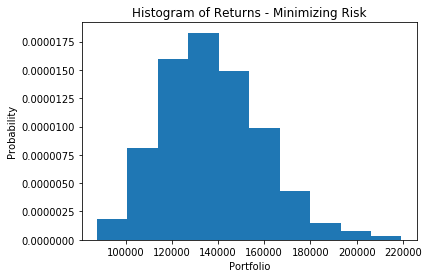

In [11]:
plt.hist(z_values, density=True)
plt.xlabel('Portfolio')
plt.ylabel('Probability')
plt.title('Histogram of Returns - Minimizing Risk')
plt.show()

#### Portfolio Optimization: Maximizing Returns (or Utility) for 𝛾=0.1, 𝛾=0.15 and 𝛾=0.2

In [12]:
simu = 1000 # I am doing 1000 simulations
T = 300 # 300 trading days
m = 6 # I have 6 assets
B = 100000 # Budget is $100000
z_values = []
for q in range(simu):
    y = np.zeros((T+1,m))
    y[0] = allocation_max_returns.iloc[0,0:6] # because the allocation are same for 𝛾=0.1, 𝛾=0.15 and 𝛾=0.2, so I select 𝛾=0.1 as a instance. 
    for i in range(T):
        rr = np.random.multivariate_normal(mu,Cov)
        y[i+1] = y[i]*(1+rr)
    z_values.append(sum(y[T])*B)

pd.DataFrame([np.mean(z_values), np.var(z_values), math.sqrt(np.var(z_values))], index=['mean', 'var', 'sd'], columns=['dollars'])

,dollars
mean,182051.75666
var,4383171192.33159
sd,66205.52237


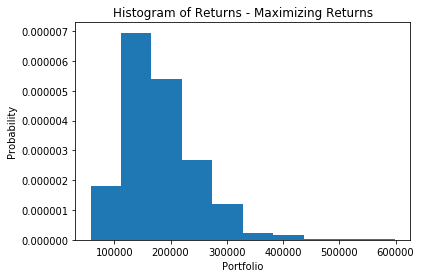

In [13]:
plt.hist(z_values, density=True)
plt.xlabel('Portfolio')
plt.ylabel('Probability')
plt.title('Histogram of Returns - Maximizing Returns')
plt.show()

### 5. Recommendations

#### a. Explain the different allocations, i.e., why they are different

The allocations are different to differnt portfolio strategies:
- Minimizing risk: The goal is not to purly maximize the returns. The goal is to select the best return with the lowet risk. So in this case, risk has higher priority than return.
- Maximizing returns: The goal is to purly maximize the returns not matter how risky the portfolio is. So in this case, risk has lower priority than return. The risk aversion coefficient 𝛾 reflects how risky a investor can bear and generally, the more risky the stock is, the larger the fluctuation of the return is.

#### b. What should an investor with risk aversion 𝛾 = 0.1 do? What about investors with 𝛾 = 0.15 and 𝛾 = 0.2?

In [14]:
allocation_max_returns

,Amazon,Apple,Ebay,Facebook,Google,Twitter,optimum_value
𝛾=0.1,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00195
𝛾=0.15,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00193
𝛾=0.2,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00191


Based on the result showing above, investor with risk aversion 𝛾 from 0.1 to 0.2 should all invest Amazon only.

## Part B: Portfolio Optimization based on the last 400 trading days

### 1. Preparing the data

In [15]:
stocks = stocks[-400:]
stocks.head()

,Amazon,Apple,Ebay,Facebook,Google,Twitter
399,687.18100,105.87000,31.06000,124.36000,797.25000,19.54000
400,676.85100,107.48000,31.39000,125.15000,806.92999,20.86000
401,674.91900,108.37000,31.15000,125.26000,805.22998,20.40000
402,685.26700,108.81000,31.11000,125.06000,807.47998,20.17000
403,691.06600,108.00000,31.12000,124.88000,808.48999,19.00000


#### E. Based on the data set, compute the rate of returns for each stock

In [16]:
rate_returns = (stocks.shift(-1) - stocks)/stocks
rate_returns.dropna(inplace=True)
rate_returns.head()

,Amazon,Apple,Ebay,Facebook,Google,Twitter
399,-0.01503,0.01521,0.01062,0.00635,0.01214,0.06755
400,-0.00285,0.00828,-0.00765,0.00088,-0.00211,-0.02205
401,0.01533,0.00406,-0.00128,-0.00160,0.00279,-0.01127
402,0.00846,-0.00744,0.00032,-0.00144,0.00125,-0.05801
403,-0.00068,-0.00065,0.00257,0.00016,-0.00036,-0.00105


#### F. Based on the data set, compute the average returns that will be used for the optimization

In [17]:
avg_returns = stats.gmean(rate_returns+1, axis=0)-1
avg_returns

array([ 0.0014643 ,  0.00126081,  0.00080563,  0.00098042,  0.0008732 ,
        0.00150318])

#### G. Based on the data set, compute the variance-covariance matrix of the stock returns

In [18]:
covariance_matrix = rate_returns.cov()
covariance_matrix

,Amazon,Apple,Ebay,Facebook,Google,Twitter
Amazon,0.00023,-0.00001,-0.00000,-0.00000,-0.00000,-0.00003
Apple,-0.00001,0.00014,0.00001,0.00000,0.00001,-0.00001
Ebay,-0.00000,0.00001,0.00024,-0.00001,0.00000,-0.00003
Facebook,-0.00000,0.00000,-0.00001,0.00016,0.00002,-0.00000
Google,-0.00000,0.00001,0.00000,0.00002,0.00012,-0.00001
Twitter,-0.00003,-0.00001,-0.00003,-0.00000,-0.00001,0.00100


#### H. Provide the vector 𝜇 and the variance-covariance matrix 𝛴 for the 6 assets considered

In [19]:
# the vector 𝜇 = rate_returns
print('the vector 𝜇 = rate_returns:')
rate_returns.head()

the vector 𝜇 = rate_returns:


,Amazon,Apple,Ebay,Facebook,Google,Twitter
399,-0.01503,0.01521,0.01062,0.00635,0.01214,0.06755
400,-0.00285,0.00828,-0.00765,0.00088,-0.00211,-0.02205
401,0.01533,0.00406,-0.00128,-0.00160,0.00279,-0.01127
402,0.00846,-0.00744,0.00032,-0.00144,0.00125,-0.05801
403,-0.00068,-0.00065,0.00257,0.00016,-0.00036,-0.00105


In [20]:
# the variance-covariance matrix = covariance_matrix
print('the variance-covariance matrix = covariance_matrix:')
covariance_matrix

the variance-covariance matrix = covariance_matrix:


,Amazon,Apple,Ebay,Facebook,Google,Twitter
Amazon,0.00023,-0.00001,-0.00000,-0.00000,-0.00000,-0.00003
Apple,-0.00001,0.00014,0.00001,0.00000,0.00001,-0.00001
Ebay,-0.00000,0.00001,0.00024,-0.00001,0.00000,-0.00003
Facebook,-0.00000,0.00000,-0.00001,0.00016,0.00002,-0.00000
Google,-0.00000,0.00001,0.00000,0.00002,0.00012,-0.00001
Twitter,-0.00003,-0.00001,-0.00003,-0.00000,-0.00001,0.00100


### 2. Portfolio Optimization: Minimizing Risk

In [21]:
R = 0.07/250
mu = avg_returns
Cov = covariance_matrix.values
x = cvx.Variable(6)

risk = quad_form(x, Cov)
rr = sum_entries(mu*x)
prob1 = Problem(Minimize(risk), 
               [rr >= R,sum_entries(x) == 1, 
                x >= 0])
prob1.solve()

allocation_min_risk = pd.DataFrame(x.value.T, columns = stocks.columns, index = ['Allocation'])
print(f'the optimum value is: {round(prob1.value,5)}')
allocation_min_risk

the optimum value is: 3e-05


,Amazon,Apple,Ebay,Facebook,Google,Twitter
Allocation,0.16299,0.22956,0.14732,0.18900,0.22479,0.04634


### 3. Portfolio Optimization: Maximizing Returns (or Utility)

In [22]:
gamma = [0.10, 0.15, 0.20]
mu = avg_returns
Cov = covariance_matrix.values
x = cvx.Variable(6)

risk = quad_form(x, Cov)
rr = sum_entries(mu*x)

allocation_max_returns_list = []
optimum_value = []
for g in gamma:
    prob2 = Problem(Maximize(rr - g*risk), 
                   [sum_entries(x) == 1, 
                    x >= 0])
    prob2.solve()

    allocation_max_returns_list.append(pd.DataFrame(x.value.T))
    optimum_value.append(prob2.value)
    
allocation_max_returns = pd.concat([allocation_max_returns_list[0], allocation_max_returns_list[1], allocation_max_returns_list[2]])
allocation_max_returns.columns = stocks.columns
allocation_max_returns.index = list(map(lambda x: '𝛾='+ str(x), gamma))
allocation_max_returns['optimum_value'] = optimum_value

allocation_max_returns

,Amazon,Apple,Ebay,Facebook,Google,Twitter,optimum_value
𝛾=0.1,0.64790,0.00000,0.00000,0.00000,0.00000,0.35210,0.00146
𝛾=0.15,0.69778,0.00000,0.00000,0.00000,0.00000,0.30222,0.00145
𝛾=0.2,0.72264,0.00000,0.00000,0.00000,0.00000,0.27736,0.00144


### 4. Simulations

#### Portfolio Optimization: Minimizing Risk

In [23]:
simu = 1000 # I am doing 1000 simulations
T = 300 # 300 trading days
m = 6 # I have 6 assets
B = 100000 # Budget is $100000
z_values = []
for q in range(simu):
    y = np.zeros((T+1,m))
    y[0] = allocation_min_risk
    for i in range(T):
        rr = np.random.multivariate_normal(mu,Cov)
        y[i+1] = y[i]*(1+rr)
    z_values.append(sum(y[T])*B)

pd.DataFrame([np.mean(z_values), np.var(z_values), math.sqrt(np.var(z_values))], index=['mean', 'var', 'sd'], columns=['dollars'])

,dollars
mean,139161.92065
var,205771598.38063
sd,14344.74114


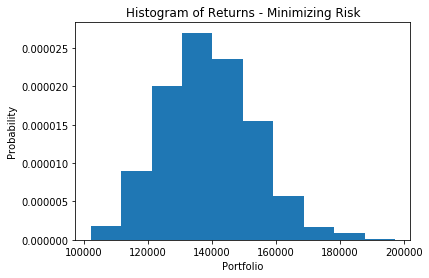

In [24]:
plt.hist(z_values, density=True)
plt.xlabel('Portfolio')
plt.ylabel('Probability')
plt.title('Histogram of Returns - Minimizing Risk')
plt.show()

#### Portfolio Optimization: Maximizing Returns (or Utility) for 𝛾=0.1

In [25]:
simu = 1000 # I am doing 1000 simulations
T = 300 # 300 trading days
m = 6 # I have 6 assets
B = 100000 # Budget is $100000
z_values = []
for q in range(simu):
    y = np.zeros((T+1,m))
    y[0] = allocation_max_returns.iloc[0,0:6]
    for i in range(T):
        rr = np.random.multivariate_normal(mu,Cov)
        y[i+1] = y[i]*(1+rr)
    z_values.append(sum(y[T])*B)

pd.DataFrame([np.mean(z_values), np.var(z_values), math.sqrt(np.var(z_values))], index=['mean', 'var', 'sd'], columns=['dollars'])

,dollars
mean,154831.42960
var,1612049845.34373
sd,40150.34054


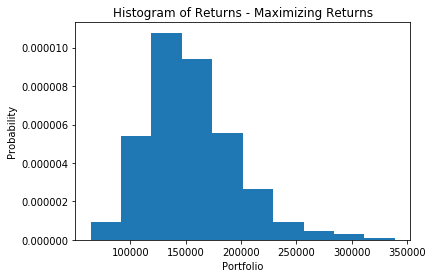

In [26]:
plt.hist(z_values, density=True)
plt.xlabel('Portfolio')
plt.ylabel('Probability')
plt.title('Histogram of Returns - Maximizing Returns')
plt.show()

#### Portfolio Optimization: Maximizing Returns (or Utility) for 𝛾=0.15

In [27]:
simu = 1000 # I am doing 1000 simulations
T = 300 # 300 trading days
m = 6 # I have 6 assets
B = 100000 # Budget is $100000
z_values = []
for q in range(simu):
    y = np.zeros((T+1,m))
    y[0] = allocation_max_returns.iloc[1,0:6]
    for i in range(T):
        rr = np.random.multivariate_normal(mu,Cov)
        y[i+1] = y[i]*(1+rr)
    z_values.append(sum(y[T])*B)

pd.DataFrame([np.mean(z_values), np.var(z_values), math.sqrt(np.var(z_values))], index=['mean', 'var', 'sd'], columns=['dollars'])

,dollars
mean,154825.99441
var,1492006678.06965
sd,38626.50228


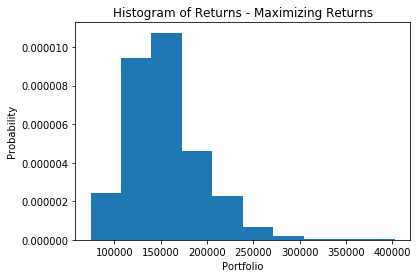

In [28]:
plt.hist(z_values, density=True)
plt.xlabel('Portfolio')
plt.ylabel('Probability')
plt.title('Histogram of Returns - Maximizing Returns')
plt.show()

#### Portfolio Optimization: Maximizing Returns (or Utility) for 𝛾=0.2

In [29]:
simu = 1000 # I am doing 1000 simulations
T = 300 # 300 trading days
m = 6 # I have 6 assets
B = 100000 # Budget is $100000
z_values = []
for q in range(simu):
    y = np.zeros((T+1,m))
    y[0] = allocation_max_returns.iloc[2,0:6]
    for i in range(T):
        rr = np.random.multivariate_normal(mu,Cov)
        y[i+1] = y[i]*(1+rr)
    z_values.append(sum(y[T])*B)

pd.DataFrame([np.mean(z_values), np.var(z_values), math.sqrt(np.var(z_values))], index=['mean', 'var', 'sd'], columns=['dollars'])

,dollars
mean,159600.04843
var,1650337223.41546
sd,40624.34274


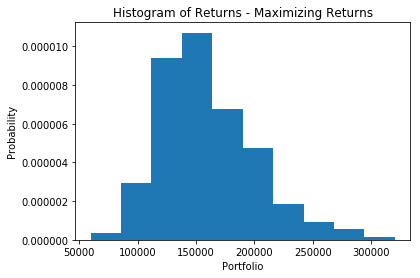

In [30]:
plt.hist(z_values, density=True)
plt.xlabel('Portfolio')
plt.ylabel('Probability')
plt.title('Histogram of Returns - Maximizing Returns')
plt.show()

### 5. Explanations

### a. Explain the different allocations, i.e., why they are different

The allocations are different to differnt portfolio strategies:
- Minimizing risk: The goal is not to purly maximize the returns. The goal is to select the best return with the lowet risk. So in this case, risk has higher priority than return.
- Maximizing returns: The goal is to purly maximize the returns not matter how risky the portfolio is. So in this case, risk has lower priority than return. The risk aversion coefficient 𝛾 reflects how risky a investor can bear and generally, the more risky the stock is, the larger the fluctuation of the return is.

### b. What should an investor with risk aversion 𝛾 = 0.1 do? What about investors with 𝛾 = 0.15 and 𝛾 = 0.2?

In [31]:
allocation_max_returns

,Amazon,Apple,Ebay,Facebook,Google,Twitter,optimum_value
𝛾=0.1,0.64790,0.00000,0.00000,0.00000,0.00000,0.35210,0.00146
𝛾=0.15,0.69778,0.00000,0.00000,0.00000,0.00000,0.30222,0.00145
𝛾=0.2,0.72264,0.00000,0.00000,0.00000,0.00000,0.27736,0.00144


Based on the result showing above, investors who have differnt risk aversion should have different allocation plan. The detailed allocation plan is demonstrated in the table above.

### c. Why are the allocations different?

#### Portfolio Optimization: Minimizing Risk - based on the overall trading days:
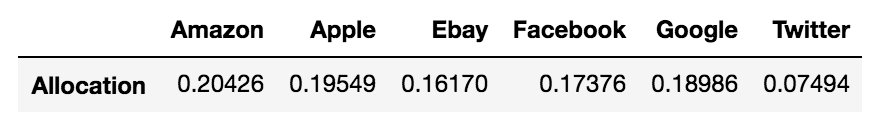

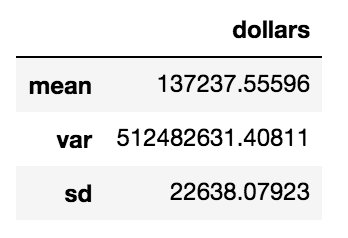

#### Portfolio Optimization: Minimizing Risk - based on the last 400 trading days:
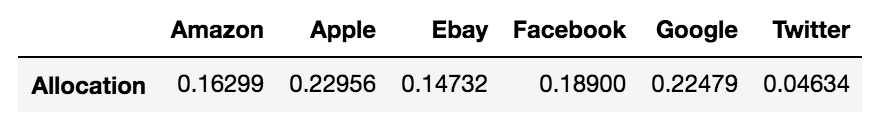

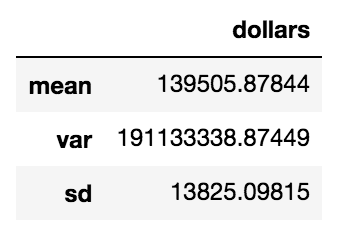

As you can see from the above comparison, in the strategy of minimizing risk, the return for the last 400 trading days is generally higher than the entire trading days while the risk for the last 400 trading days is overall lower than the overall trading days.<br><br>
This means the stock in the last 400 days performed better than the overall trading days although the specific circumstances of each stock had different changes. And this is the reason why the allocation changed.

#### Portfolio Optimization: Maximizing Returns (or Utility) - based on the overall trading days:
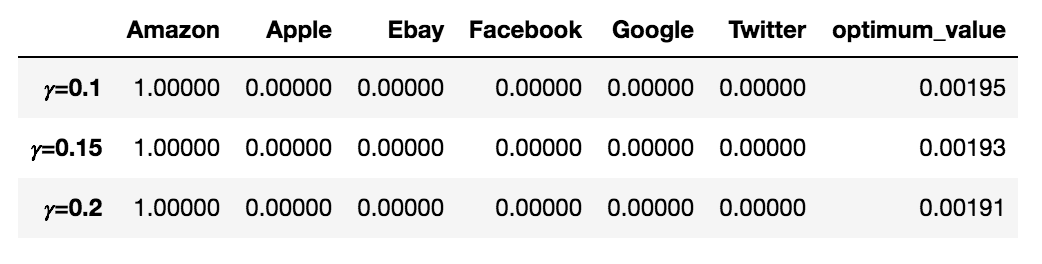

#### for 𝛾=0.1:
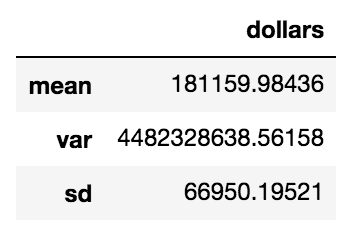

#### Portfolio Optimization: Maximizing Returns (or Utility) - based on the last 400 trading days:
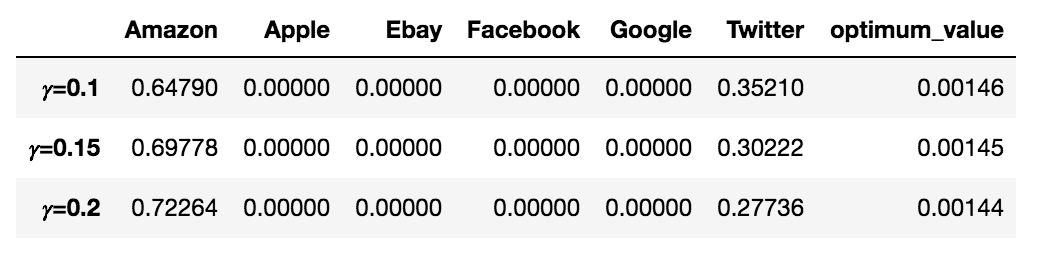

#### for 𝛾=0.1:
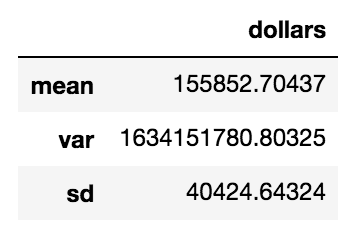

Both the return and risk for the the last 400 trading days are less than the overall trading days. This means the stock market of the 6 companies performed more stable in the last 400 trading days. These stocks are overall performed less risky but also less profitable.<br><br>
For the analysis on the overall trading days, the suggested allocation is to invest Amazon only with the risk aversion range from 0.1 to 0.2. But for the analysis on the last 400 trading days, the suggested allocation is to invest Amazon and Twitter and the weight for each are differnt in differnt risk aversion levels. This change is caused by the companies' stock market change. These stocks are overall performed less risky but also less profitable.